In [91]:
import sys,os, glob, time, warnings, pickle
sys.path.append('/data/fragosta/work/lsst/sims_maf_contrib-master/')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from builtins import zip
from itertools import combinations
from astropy import units as u
from astropy.coordinates import SkyCoord
import astropy.coordinates as coor
from astropy.coordinates import (CartesianRepresentation,
                                 CartesianDifferential, Galactic)
from astropy.io import ascii
from astropy import units
from scipy.stats import gennorm

## MilkyWay model

Galpy contains a number of potentials to model shapes and features of a galaxy. 

In [2]:
import galpy.potential
from galpy.util import bovy_conversion
print([p for p in dir(galpy.potential) if 'Potential' in p])

A new version of galpy (1.8.3) is available, please upgrade using pip/conda/... to get the latest features and bug fixes!
/home/idies/lsst/conda/miniconda3-py38_4.9.2/envs/rubin/lib/python3.10/site-packages/galpy/util/bovy_conversion.py:8: FutureWarning: galpy.util.bovy_conversion is being deprecated in favor of galpy.util.conversion; all functions in there are the same; please switch to the new import, because the old import will be removed in v1.9
  warnings.warn('galpy.util.bovy_conversion is being deprecated in favor of galpy.util.conversion; all functions in there are the same; please switch to the new import, because the old import will be removed in v1.9',FutureWarning)

['AdiabaticContractionWrapperPotential', 'AnyAxisymmetricRazorThinDiskPotential', 'AnySphericalPotential', 'BurkertPotential', 'CorotatingRotationWrapperPotential', 'CosmphiDiskPotential', 'DehnenBarPotential', 'DehnenCoreSphericalPotential', 'DehnenSmoothWrapperPotential', 'DehnenSphericalPotential', 'DiskSCFPo

Galpy use the variable los in the function to [sample the disk velocity](screenshotgalpy2.png), however this variable is passed to [sampledSurfacemassLOS](screenshotgalpy1.png) function which takes as input the galactic longitude, to sample the stars along the line of sight it uses the equation $R^2 = d^2+R_0^2-2d*R_0cos(gl)$ , which comes from this schema![](./lineofsight_schema.png). Thus we can sample distances along the line of sight, fixing the position estimating the array of galactic longitudes.
We need to project the 3D distance we used as input in astropy to the 2D distance on the Galactic plane.

The reccomended potential models to describe the Milky Way potential are

In [96]:
from galpy.potential import NFWPotential, MiyamotoNagaiPotential, PowerSphericalPotentialwCutoff
from galpy.potential import evaluateDensities

However for the Disk components it does not have the possibility to separate the thin and the thick disk from the genearal MiyamotoNagaiPotential.

In [346]:
Disk_pot= MiyamotoNagaiPotential(a=3./8*units.kpc,b=0.28/8*units.kpc,normalize=.6)
Halo_pot= NFWPotential(a=16/8*units.kpc,normalize=.35)
Bulge_pot= PowerSphericalPotentialwCutoff(alpha=1.8,rc=1.9/8*units.kpc,normalize=1.)

In [164]:
R,z = np.linspace(-20,20,1000), np.linspace(-20,20,1000)
rho_disk = []
rho_halo = []
rho_bulge = []
for r in R:
    #for zz in z1
        rho_disk.append(Disk_pot.dens(r/8,0.2/8))
        rho_halo.append(Halo_pot.dens(r/8,0.2/8))
        rho_bulge.append(Bulge_pot.dens(r/8,0.2/8))

To analyse contribution of each component we can plot the density of disk, halo and bulge, normalized with respect the sum of the three.

The normalization is with respect the total mass, so that the intergal under the curve is 1

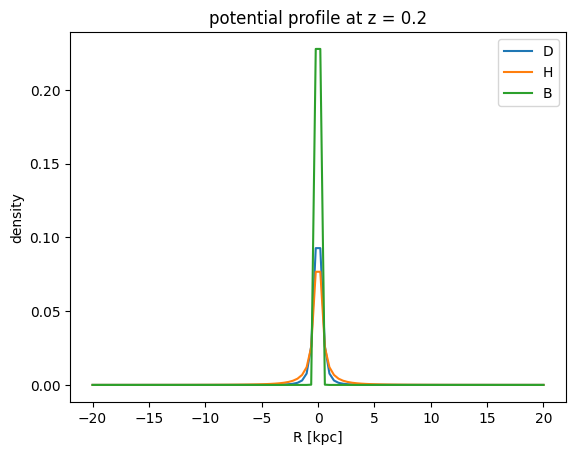

In [11]:
plt.plot(R,rho_disk/np.sum(rho_disk+rho_halo+rho_bulge),label = 'D')
plt.plot(R,rho_halo/np.sum(rho_disk+rho_halo+rho_bulge),label = 'H')
plt.plot(R,rho_bulge/np.sum(rho_disk+rho_halo+rho_bulge),label = 'B')
plt.ylabel('density')
plt.xlabel('R [kpc]')
plt.title('potential profile at z = {}'.format(0.2))
plt.legend();

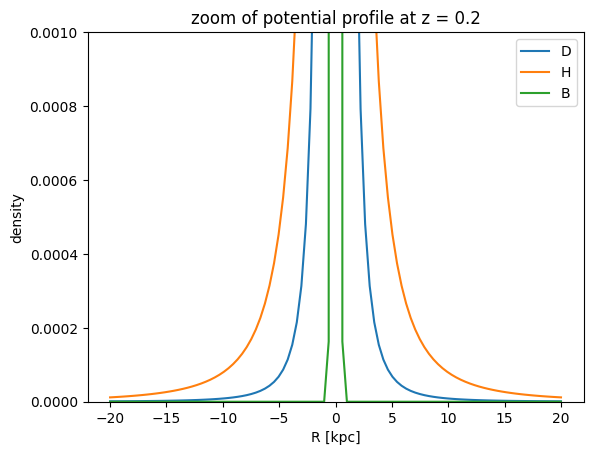

In [12]:
plt.plot(R,rho_disk/np.sum(rho_disk+rho_halo+rho_bulge),label = 'D')
plt.plot(R,rho_halo/np.sum(rho_disk+rho_halo+rho_bulge),label = 'H')
plt.plot(R,rho_bulge/np.sum(rho_disk+rho_halo+rho_bulge),label = 'B')
plt.title('zoom of potential profile at z = {}'.format(0.2))
plt.ylim([0,1e-3])
plt.ylabel('density')
plt.xlabel('R [kpc]')
plt.legend();

For each location in the Sky we can evaluate the fraction of the sample to be from the Disk, the Halo or the Bulge

In [165]:
xx,yy = np.meshgrid(R,z)
rho_arr =np.array([Disk_pot.dens(xx/8,yy/8), Halo_pot.dens(xx/8,yy/8), Bulge_pot.dens(xx/8,yy/8)])

In [170]:
rho_arr.max(axis=1)

array([[0.02148701, 0.02161653, 0.0217471 , ..., 0.0217471 , 0.02161653,
        0.02148701],
       [0.00181999, 0.0018303 , 0.00184068, ..., 0.00184068, 0.0018303 ,
        0.00181999],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

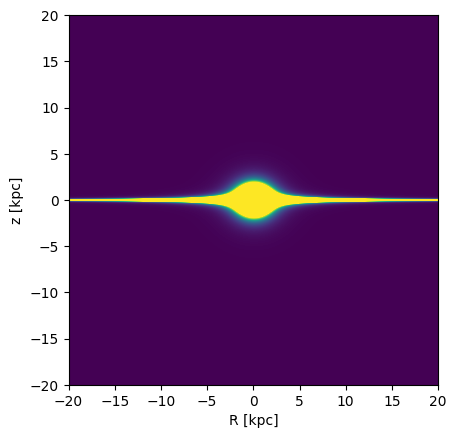

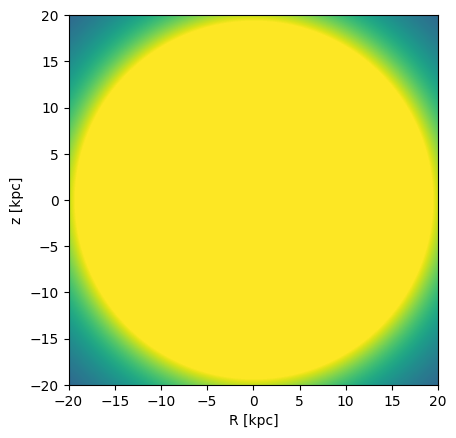

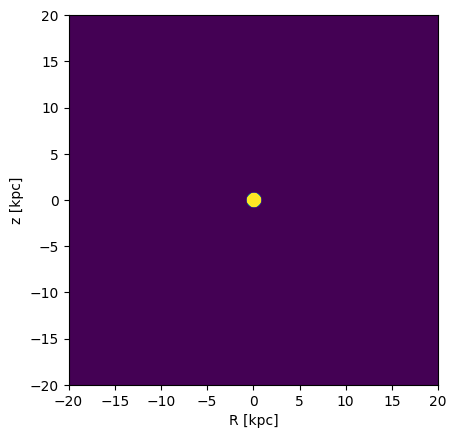

In [171]:
for i in range(3):
    plt.figure()
    plt.imshow(rho_arr[i],extent=[-20,20,-20,20],aspect='equal',vmin=0,vmax = 0.002)
    plt.xlabel('R [kpc]')
    plt.ylabel('z [kpc]')
    #plt.ylim([-15,15])
    #plt.xlim([-20,20])
    plt.show()


In [338]:
x,y,z = np.linspace(-20,20,100),np.linspace(-20,20,100),np.linspace(-20,20,100)
X,Y,Z= np.meshgrid(x,y,z)
R_from_cart = np.sqrt((X)**2+ (Y)**2)

In [347]:
rho_arr =np.array([Disk_pot.dens(R_from_cart/8,Z/8), 
                   Halo_pot.dens(R_from_cart/8,Z/8), 
                   Bulge_pot.dens(R_from_cart/8,Z/8)])

In [378]:
a = rho_arr[2][idx_]/rho_arr[2][idx_].max()
print([a.min(),a.max()])

[9.64739619448057e-12, 1.0]


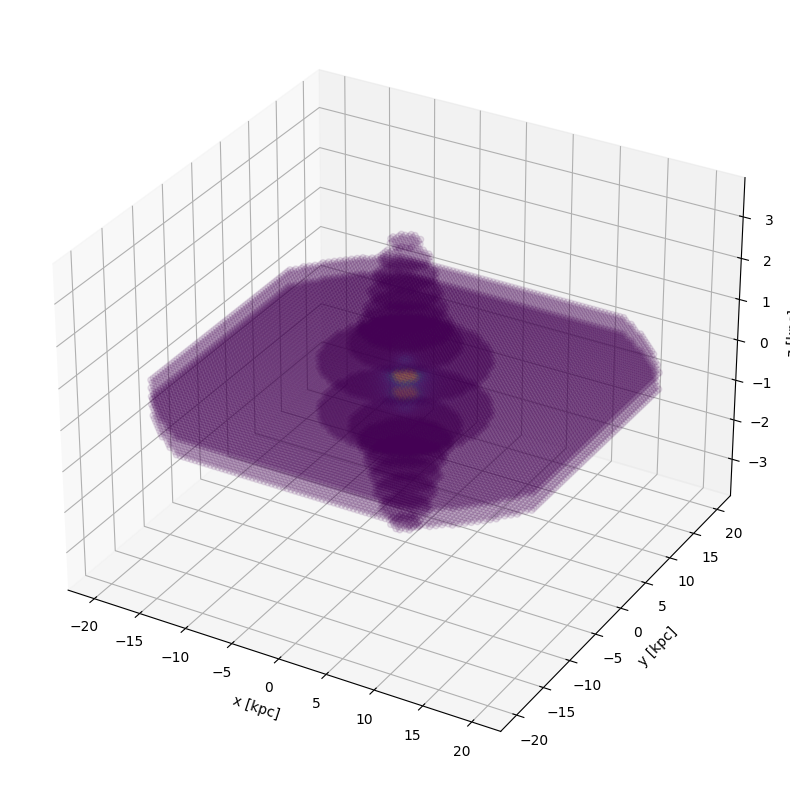

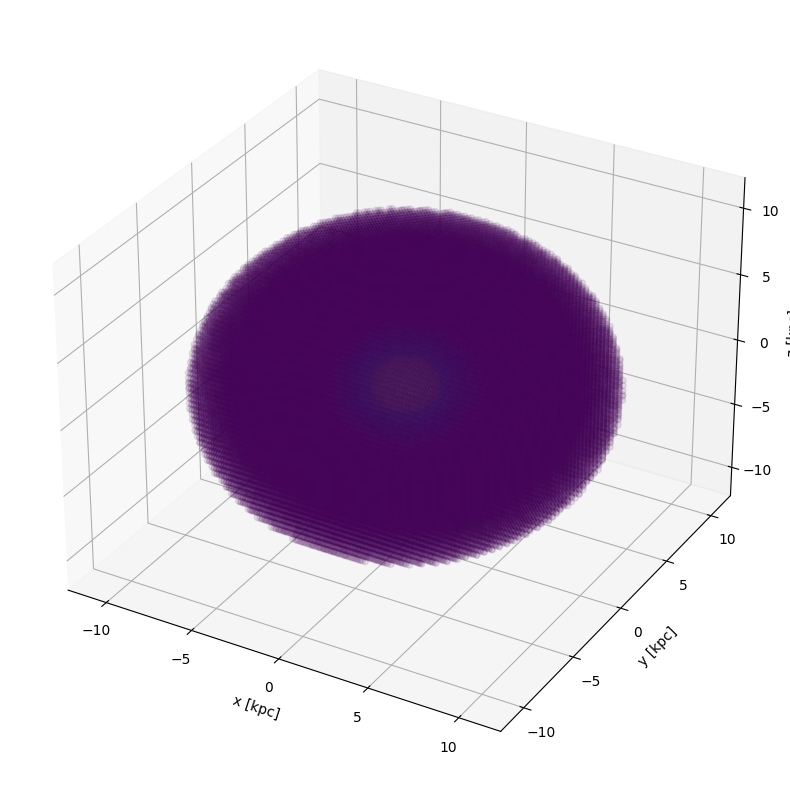

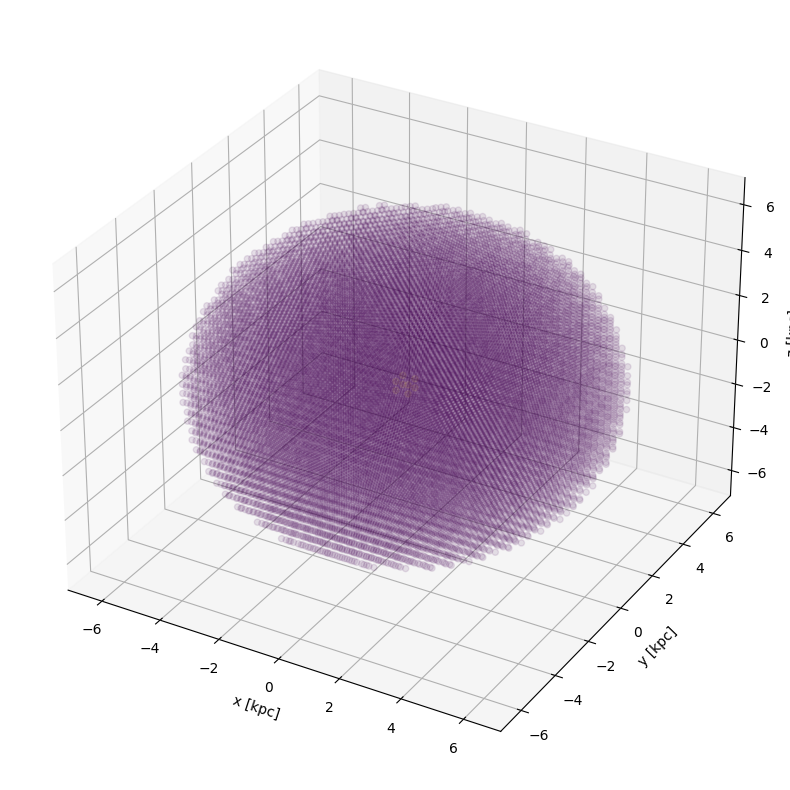

In [380]:
for i, a in enumerate([1e-4,1e-2,0]):
    idx_ = np.where(rho_arr[i]>a)
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(10,10))
    surf=ax.scatter(X[idx_], Y[idx_], Z[idx_],c=rho_arr[i][idx_]/rho_arr[i][idx_].max(),alpha=0.1,depthshade=True, vmin=0,vmax=0.1)
    ax.set_xlabel('x [kpc]')
    ax.set_ylabel('y [kpc]')
    ax.set_zlabel('z [kpc]')


Once the gravitational model is defined, the corrispondent velocity distribution function can be associated:

- isotropicNFWdf -> Halo
- kingdf -> Bulge
- dehnendf -> disk

In [98]:
from galpy.df import isotropicNFWdf, kingdf, dehnendf
N=5000

for each R,z we can define a distribution function for the fraction of the sample that come from each galactic component.

In [109]:
Disk_fraction=Disk_pot.dens(R=R[2]/8,z=0.2/8)/(Halo_pot.dens(R=R[2]/8,z=0.2/8)+Bulge_pot.dens(R=R[2]/8,z=0.2/8)+Disk_pot.dens(R=R[2]/8,z=0.2/8))
Halo_fraction=Halo_pot.dens(R=R[2]/8,z=0.2/8)/(Halo_pot.dens(R=R[2]/8,z=0.2/8)+Bulge_pot.dens(R=R[2]/8,z=0.2/8)+Disk_pot.dens(R=R[2]/8,z=0.2/8))
Bulge_fraction=Bulge_pot.dens(R=R[2]/8,z=0.2/8)/(Halo_pot.dens(R=R[2]/8,z=0.2/8)+Bulge_pot.dens(R=R[2]/8,z=0.2/8)+Disk_pot.dens(R=R[2]/8,z=0.2/8))

In [110]:
[Disk_fraction,
Halo_fraction,
Bulge_fraction]

[0.10492435695345279, 0.8950756430465473, 0.0]

In [112]:
Nbulge = int(Bulge_fraction*N*Bulge_pot.dens(R=R[2]/8,z=0.2/8))
Nhalo = int(Halo_fraction*N*Halo_pot.dens(R=R[2]/8,z=0.2/8))
Ndisk = int(Disk_fraction*N*Disk_pot.dens(R=R[2]/8,z=0.2/8))

In [113]:
[Nbulge,
Nhalo,
Ndisk]

[0, 86, 1]

In [114]:
halo_df= isotropicNFWdf(pot=Halo_pot)
sample_h= halo_df.sample(R=R[10]/8, z=0.2/8,n =Nhalo).vT() 
bulge_df = kingdf(M=2.3,rt=1.4,W0=3.)
sample_b= bulge_df.sample(R=R[10]/8, z=0.2/8, n=Nbulge).vT()

In [115]:
disk_df = dehnendf(beta=0.,profileParams=(1./4.,1.,0.2))

In [116]:
import itertools
sample_d = list(itertools.chain.from_iterable([disk_df.sample(n = Ndisk, los= l,returnOrbit=False)\
                                               for l in ls[~np.isnan(ls)]]))

/home/idies/lsst/conda/miniconda3-py38_4.9.2/envs/rubin/lib/python3.10/site-packages/galpy/df/diskdf.py:1717: RuntimeWarning: overflow encountered in exp
  return self._gamma*numpy.exp(logsigmaR2-SRE2+self.targetSurfacemass(xE,log=True,use_physical=False)-logSigmaR+numpy.exp(logOLLE-SRE2)+correction[0])/2./numpy.pi



In [117]:
sample_d = [s.vT() for s in sample_d]

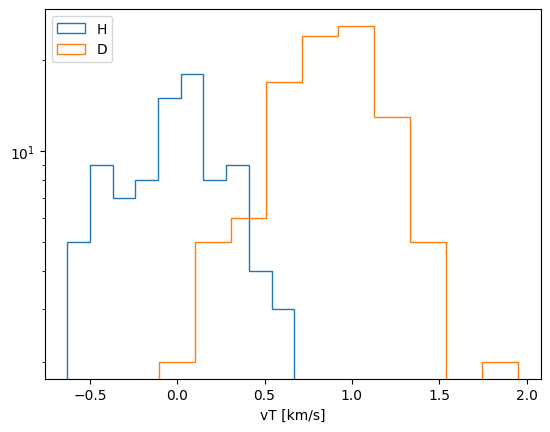

In [118]:
if np.array(sample_h).size!=0:
    plt.hist(sample_h,histtype='step', label='H')
if np.array(sample_d).size!=0:
    plt.hist(sample_d,histtype='step', label='D')
if np.array(sample_b).size!=0:
    plt.hist(sample_b,histtype='step', label='B')
plt.xlabel('vT [km/s]')
plt.yscale('log')
plt.legend()

As expected, in the location (R,z) = 8.4, 0.2 we can find most Halo and Disk stars, and the histogram show the velocity distribution of those stars.

To each star in the sample is associated a magnitude from an isochrone produced by BaSTI ( http://basti-iac.oa-abruzzo.inaf.it/isocs.html ) considering age and metallicity of the galactic component.

In [120]:
Bulge_magdist = np.array(ascii.read('Bulge.isc_sloan')['col6']) #for g band distribution
Disk_magdist = np.array(ascii.read('Disk.isc_sloan')['col6']) #for g band distribution
Halo_magdist = np.array(ascii.read('Halo.isc_sloan')['col6']) #for g band distribution

#drawing samples from isochrones
sample_mb = np.random.choice(Bulge_magdist, Nbulge)
sample_md = np.random.choice(Disk_magdist, ls[~np.isnan(ls)].size*Ndisk)
sample_mh = np.random.choice(Halo_magdist, Nhalo)


Text(0.5, 0, 'absolute magnitude')

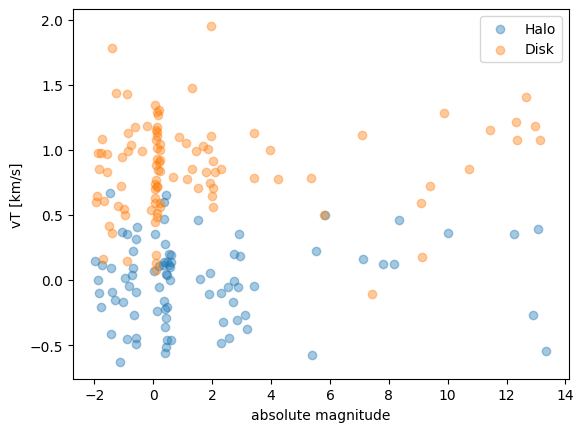

In [121]:
plt.scatter(sample_mh,sample_h, label='Halo',alpha=0.4)
plt.scatter(sample_md,sample_d, label='Disk',alpha=0.4)
plt.legend()
plt.ylabel('vT [km/s]')
plt.xlabel('absolute magnitude')

In [66]:
t=[]
tsum = []
tt=0
for n in np.arange(1,500,50):
    start = time.time() 
    temp_var = disk_df.sample(n = n, los= 0*u.deg)
    t.append(time.time()-start)
    tt += time.time()-start
    tsum.append(tt)

/home/idies/lsst/conda/miniconda3-py38_4.9.2/envs/rubin/lib/python3.10/site-packages/galpy/df/diskdf.py:512: RuntimeWarning: divide by zero encountered in double_scalars
  if surfmassatprop/maxSM > numpy.random.random(): #accept

/home/idies/lsst/conda/miniconda3-py38_4.9.2/envs/rubin/lib/python3.10/site-packages/galpy/df/diskdf.py:512: RuntimeWarning: divide by zero encountered in double_scalars
  if surfmassatprop/maxSM > numpy.random.random(): #accept

/home/idies/lsst/conda/miniconda3-py38_4.9.2/envs/rubin/lib/python3.10/site-packages/galpy/df/diskdf.py:1717: RuntimeWarning: overflow encountered in exp
  return self._gamma*numpy.exp(logsigmaR2-SRE2+self.targetSurfacemass(xE,log=True,use_physical=False)-logSigmaR+numpy.exp(logOLLE-SRE2)+correction[0])/2./numpy.pi

/home/idies/lsst/conda/miniconda3-py38_4.9.2/envs/rubin/lib/python3.10/site-packages/galpy/df/diskdf.py:512: RuntimeWarning: divide by zero encountered in double_scalars
  if surfmassatprop/maxSM > numpy.random.random(): #

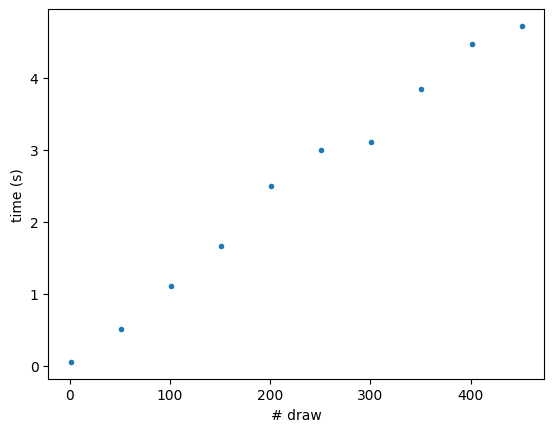

In [67]:
plt.plot(np.arange(1,500,50), np.array(t),'.')
plt.ylabel('time (s)')
plt.xlabel('# draw')
plt.show()

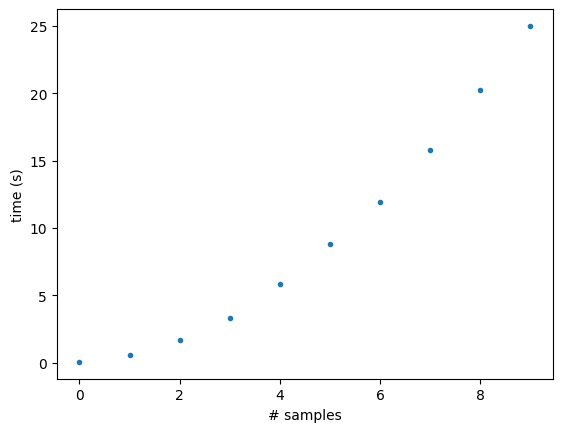

In [68]:
plt.plot(np.arange(1,500,50)//50, np.array(tsum),'.')
plt.ylabel('time (s)')
plt.xlabel('# samples')
plt.show()

In [70]:
from scipy.optimize import curve_fit
def fitcurve(x,a,b):
    return b*x**a

popt, pcov = curve_fit(fitcurve,np.arange(1,500,50)//50, np.array(tsum))
print('dim(N)= {} samples take {} days'.format(14052,
fitcurve(14052,popt[0],popt[1])/3600/24))

dim(N)= 14052 samples take 160.72829816935172 days
